<a href="https://colab.research.google.com/github/robertosgpontes/osem/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Formulação do Problema

O problema apresentado pode ser formulado através de uma

\begin{equation}
	\max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i}
\end{equation}
e
\begin{equation}
\min \sum_{i=1}^{n}{C_iX_i}
\end{equation}


Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [1]:
% pip install pulp

     |████████████████████████████████| 40.6 MB 32 kB/s 


https://www.supplychaindataanalytics.com/multi-objective-linear-optimization-with-pulp-in-python/

https://pythonhealthcare.org/tag/pareto-front/

In [2]:
# Python libraries used to solve the problem Linear Programing
import pulp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
NUM_ITER = 1000

In [4]:
# Variáveis do modelo

A1 = np.array([11.444, 0.047, 1.523, 0.095])
A2 = np.array([0.899, 0.0, 0.926, 0.073]) 
A3 = np.array([0.00106, 0.00010, 0.00021, 0.00006])
C = np.array([1.41, 4.99, 2.41, 6.24])
A = np.array([  [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 1, 0],
                [1, 1, 1, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

b = np.array([[557],[1143],[1577],[1700],[10310],[160],[6990]])

In [5]:
def create_x_variables():
    x1 = pulp.LpVariable("x1",lowBound = 0) 
    x2 = pulp.LpVariable("x2",lowBound = 0)
    x3 = pulp.LpVariable("x3",lowBound = 0) 
    x4 = pulp.LpVariable("x4",lowBound = 0) 
    return np.array([[x1], [x2], [x3], [x4]]) 

In [6]:
def load_model(lpm, A, X, b):
    Ax = A.dot(X)

    for i in range(0,4):
        lpm += Ax[i,0] <= b[i,0]

    lpm += Ax[4,0] == b[4,0]

    for i in range(5,7):
        lpm += Ax[i,0] >= b[i,0]

    return lpm

# Approach 1: Solution with Hierarchical Methodology

Maximizing for one objective, then adding it as a constraint and solving for the other objective

## 1.1. First Step

\begin{equation}
S_1 = \max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [7]:
linearProblem = pulp.LpProblem("First_Objective_Max",pulp.LpMaximize)

X = create_x_variables()

f1 = (A1 - (A2 + A3))*X.T

linearProblem += f1.sum()

linearProblem = load_model(linearProblem, A, X, b)

linearProblem.writeLP('modelStep1.lp')

solution = linearProblem.solve()

f1_max = pulp.value(linearProblem.objective)

In [8]:
# print(linearProblem)

In [9]:
print("#1 - " + str(pulp.LpStatus[solution])+" ; max value = "+str(pulp.value(linearProblem.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

#1 - Optimal ; max value = 6958.914550000001 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


## 1.1. Second Step


\begin{equation}
\min \sum_{i=1}^{n}{C_iX_i}
\end{equation}
Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} \geq S_1
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [10]:
linearProblem2 = pulp.LpProblem("Second_Objective_Min",pulp.LpMinimize)

X = create_x_variables()

linearProblem2 += C.dot(X)[0]

linearProblem2 = load_model(linearProblem2, A, X, b)

f1 = (A1 - (A2 + A3))*X.T

linearProblem2 += f1.sum() >= f1_max

linearProblem2.writeLP('modelStep2.lp')

solution2 = linearProblem2.solve()

In [11]:
print(linearProblem2)

Second_Objective_Min:
MINIMIZE
1.41*x1 + 4.99*x2 + 2.41*x3 + 6.24*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

_C8: 10.54394 x1 + 0.0469 x2 + 0.59679 x3 + 0.02194 x4 >= 6958.91455

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous



In [12]:
print(str(pulp.LpStatus[solution2])+" ; max value = "+str(pulp.value(linearProblem2.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

Optimal ; max value = 46503.9 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


# 2. Solution with ...

\begin{equation}
	\max  \alpha\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} - (1-\alpha)\sum_{i=1}^{n}{C_iX_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 \leq b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

In [13]:
def f_alpha(alpha, f1, f2):
  return (alpha*f1 - (1-alpha)*f2)

In [14]:
def run_models(f_alphas):
  solution_lst = []
  i = 0
  for alpha in f_alphas:
    model = pulp.LpProblem("MultiObjetivo", pulp.LpMaximize)

    X = create_x_variables()

    f1 = (A1 - (A2 + A3))*X.T
    f1 = f1.sum()

    f2 = C.dot(X)[0]

    model += f_alpha(alpha, f1, f2)

    model = load_model(model, A, X, b)

    solution = model.solve()

    print(model)

    X2 = np.array([pulp.value(X[0][0]), 
                    pulp.value(X[1][0]), 
                    pulp.value(X[2][0]), 
                    pulp.value(X[3][0])])
    
    solution_lst.append([i,
                    alpha,
                    str(pulp.LpStatus[solution]),
                    pulp.value(X[0][0]), 
                    pulp.value(X[1][0]), 
                    pulp.value(X[2][0]), 
                    pulp.value(X[3][0]),
                    pulp.value(model.objective),
                    ((A1 - (A2 + A3))*X2.T).sum(),
                    C.dot(X2)]
                    )
    i += 1
    
  return pd.DataFrame(solution_lst, columns=["iter","alpha","status","x1","x2", "x3", "x4", "obj_value", "f1", "f2"])

In [15]:
sig = lambda sigma: 1/(1 + np.exp(sigma*(np.linspace(0, NUM_ITER, NUM_ITER)-(NUM_ITER/2))))

In [16]:
f_alpha_lin = np.linspace(0, 1, NUM_ITER)

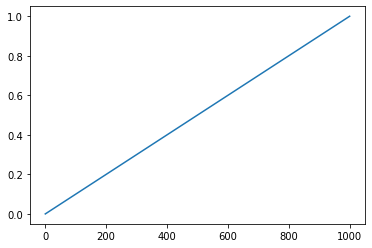

In [17]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), f_alpha_lin)

In [18]:
df_solution_lin = run_models(f_alpha_lin)

A saída de streaming foi truncada nas últimas 5000 linhas.
_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
8.066997477477479*x1 + -0.996781981981982*x2 + -0.026238558558558722*x3 + -1.275579099099099*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
8.078963383383384*x1 + -0.9917400400400402*x2 + -0.02322875875875896*x3 + -1.269310890890891*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
8.09092928928929*x1 + -0.9866980980980983*x2 + -0.020218958958959254*x3 + -1.263042682682683*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: 

In [19]:
df_solution_lin

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.000000,Optimal,557.0,8610.0,1143.0,0.0,-46503.900000,6958.91455,46503.9
1,1,0.001001,Optimal,557.0,8610.0,1143.0,0.0,-46450.383669,6958.91455,46503.9
2,2,0.002002,Optimal,557.0,8610.0,1143.0,0.0,-46396.867338,6958.91455,46503.9
3,3,0.003003,Optimal,557.0,8610.0,1143.0,0.0,-46343.351007,6958.91455,46503.9
4,4,0.004004,Optimal,557.0,8610.0,1143.0,0.0,-46289.834676,6958.91455,46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,0.995996,Optimal,557.0,8610.0,1143.0,0.0,6744.849226,6958.91455,46503.9
996,996,0.996997,Optimal,557.0,8610.0,1143.0,0.0,6798.365557,6958.91455,46503.9
997,997,0.997998,Optimal,557.0,8610.0,1143.0,0.0,6851.881888,6958.91455,46503.9
998,998,0.998999,Optimal,557.0,8610.0,1143.0,0.0,6905.398219,6958.91455,46503.9


In [20]:
f_alpha_sig_004 = sig(-0.004)

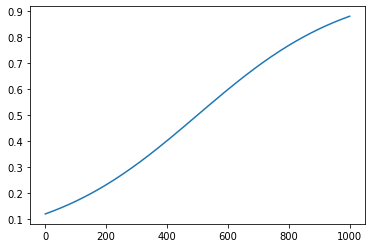

In [21]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), f_alpha_sig_004)

In [22]:
df_solution_sig_004 = run_models(f_alpha_sig_004)

A saída de streaming foi truncada nas últimas 5000 linhas.
_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
7.715119535029824*x1 + -1.1450489139152686*x2 + -0.1147468728526061*x3 + -1.4599064893094122*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
7.7237566576499805*x1 + -1.1414095847128911*x2 + -0.11257436622106343*x3 + -1.455382027615605*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
7.73237553424806*x1 + -1.1377779436358177*x2 + -0.11040644903506935*x3 + -1.4508671238997937*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3:

In [23]:
df_solution_sig_004

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.119203,Optimal,557.0,8610.0,1143.0,0.0,-40130.976286,6958.91455,46503.9
1,1,0.119624,Optimal,557.0,8610.0,1143.0,0.0,-40108.466509,6958.91455,46503.9
2,2,0.120046,Optimal,557.0,8610.0,1143.0,0.0,-40085.888062,6958.91455,46503.9
3,3,0.120470,Optimal,557.0,8610.0,1143.0,0.0,-40063.240812,6958.91455,46503.9
4,4,0.120895,Optimal,557.0,8610.0,1143.0,0.0,-40040.524625,6958.91455,46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,0.879105,Optimal,557.0,8610.0,1143.0,0.0,495.539175,6958.91455,46503.9
996,996,0.879530,Optimal,557.0,8610.0,1143.0,0.0,518.255362,6958.91455,46503.9
997,997,0.879954,Optimal,557.0,8610.0,1143.0,0.0,540.902612,6958.91455,46503.9
998,998,0.880376,Optimal,557.0,8610.0,1143.0,0.0,563.481059,6958.91455,46503.9


In [24]:
f_alpha_sig_06 = sig(-0.06)

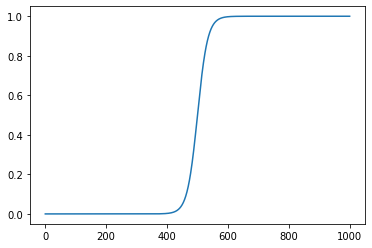

In [25]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), f_alpha_sig_06)

In [26]:
df_solution_sig_06 = run_models(f_alpha_sig_06)

A saída de streaming foi truncada nas últimas 5000 linhas.
_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
10.543939719447977*x1 + 0.046899881786884735*x2 + 0.5967899294323862*x3 + 0.021939853035908004*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
10.54393973580192*x1 + 0.046899888677765685*x2 + 0.5967899335459148*x3 + 0.02193986160274138*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous

MultiObjetivo:
MAXIMIZE
10.543939751202563*x1 + 0.04689989516696456*x2 + 0.5967899374196582*x3 + 0.02193986967019835*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3

In [27]:
df_solution_sig_06

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,9.357623e-14,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
1,1,9.936863e-14,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
2,2,1.055196e-13,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
3,3,1.120513e-13,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
4,4,1.189873e-13,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9
996,996,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9
997,997,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9
998,998,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9


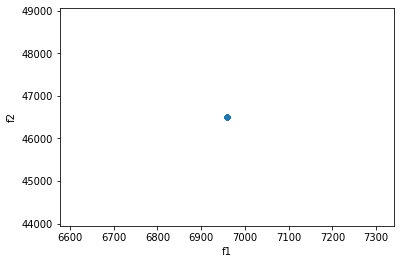

In [28]:
df_solution_sig_06.plot.scatter(x='f1', y='f2')